# Using MobileNet for our Trash Classifer

### Loading the MobileNet Model

Freeze all layers except the top 4, as we'll only be training the top 4

In [1]:
from keras.applications import MobileNet

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

Using TensorFlow backend.


0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

# Let's make a function that returns our FC Head

In [6]:
def addTopModelMobileNet(bottom_model, num_classes):
    #creates the top or head of the model that will be
    #placed ontop of the bottom layers

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

### Let's add our FC Head back onto MobileNet

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 5

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

### Loading Dataset

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = './trashData/train'
validation_data_dir = './trashData/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 1500 images belonging to 5 classes.
Found 890 images belonging to 5 classes.


### Training out Model
- Note we're using checkpointing and early stopping

In [16]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("./trash_mobilenet.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.0001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 1500
nb_validation_samples = 890

# We only train 5 EPOCHS 
epochs = 20
batch_size = 5

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/20
300/300 [==============================] - 149s 498ms/step - loss: 0.6280 - accuracy: 0.7514 - val_loss: 1.0668 - val_accuracy: 0.6607

Epoch 00001: val_accuracy improved from -inf to 0.66067, saving model to ./trash_mobilenet.h5
Epoch 2/20
300/300 [==============================] - 141s 470ms/step - loss: 0.3635 - accuracy: 0.8599 - val_loss: 2.0865 - val_accuracy: 0.7831

Epoch 00002: val_accuracy improved from 0.66067 to 0.78315, saving model to ./trash_mobilenet.h5
Epoch 3/20
300/300 [==============================] - 142s 473ms/step - loss: 0.2670 - accuracy: 0.8999 - val_loss: 2.1866 - val_accuracy: 0.7652

Epoch 00003: val_accuracy did not improve from 0.78315
Epoch 4/20
300/300 [==============================] - 141s 468ms/step - loss: 0.2162 - accuracy: 0.9204 - val_loss: 1.4642 - val_accuracy: 0.7303

Epoch 00004: val_accuracy did not improve from 0.78315
Epoch 5/20
300/300 [==============================] - 141s 471ms/step - loss: 0.1744 - accuracy: 0.9322 - val_l

### Loading our classifer


In [8]:
from keras.models import load_model
import tensorflow as tf
classifier = load_model('./trash_mobilenet.h5')
#new_model= tf.keras.models.load_model(filepath="trash_vgg.h5")
#tflite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
#tflite_model = tflite_converter.convert()
#open("trash_mobilenet.tflite", "wb").write(tflite_model)

### Testing our classifer on some test images

metal
[2]
[[1.7114502e-04 3.4010985e-01 3.5354507e-01 3.1742726e-02 2.7443114e-01]]


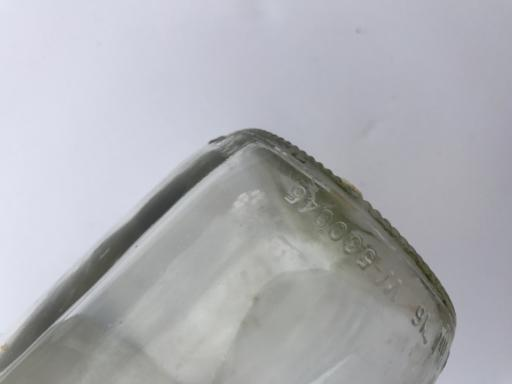

In [11]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing import image
from IPython.display import Image
trash_dict = {"[0]": "cardboard ", 
                      "[1]": "glass",
                      "[2]": "metal",
                      "[3]": "paper",
                      "[4]": "plastic "}

#cv2.destroyAllWindows()
#subject = "./trashData/validation//n1/cardboard301.jpg"
subject = "./trashData/validation//n1/glass310.jpg"
input_im = cv2.imread(subject)  
input_original = input_im.copy()
input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
input_im = input_im / 255.
input_im = input_im.reshape(1,224,224,3) 
    
# Get Prediction
res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
print(trash_dict[str(res)])
print(res)
print(classifier.predict(input_im, 1, verbose = 0))
Image(filename = subject)

Found 890 images belonging to 5 classes.
Confusion Matrix
[[ 42   1   4  53   3]
 [  0 165   8   2  26]
 [  0   5  88   1  16]
 [  7   5   4 265  13]
 [  0  21   8  11 142]]
Classification Report
              precision    recall  f1-score   support

          n0       0.86      0.41      0.55       103
          n1       0.84      0.82      0.83       201
          n2       0.79      0.80      0.79       110
          n3       0.80      0.90      0.85       294
          n4       0.71      0.78      0.74       182

    accuracy                           0.79       890
   macro avg       0.80      0.74      0.75       890
weighted avg       0.79      0.79      0.78       890



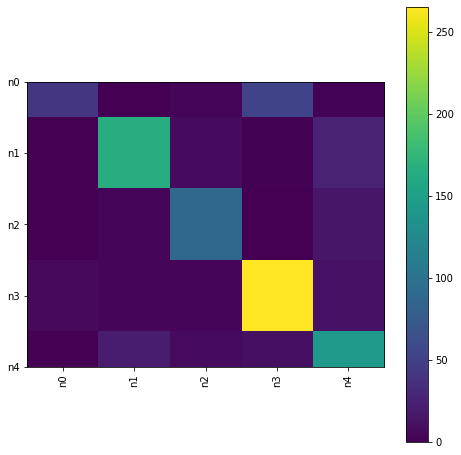

In [14]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = classifier.predict_generator(validation_generator, nb_validation_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)